# Machine Learning exercise 2: Fruit 360 classification
2021 06 21 Maarten Pennings Created

I followed "Using Python to Implement a Complete Machine Learning Flow", a Doulos Webinar by John Aynsley.

With this notebook, I try to replicate John's second example.

## The project directory

Check my first exercise for details. Basically you need

- Python on your system
- Start with an empty _project_ directory; then copy `requirements.txt`, `setup.bat`, `run.bat`, and `fruitfind.ipynb` into it.
- Run `setup.bat` to create a virtual Python environment (in subdirectory `env` in the project dictctory).
- Note that several packages will be installed (including Jupyter), as listed in `requirements.txt`.
- Run `run.bat` to run the Jupyter server and client (web page in you browser).
- Open this file (`fruitfind.ipynb`).

## Getting the data

Download [A dataset with 90380 images of 131 fruits and vegetables](https://www.kaggle.com/moltean/fruits) from Kaggle. 
You get a zip file of 760 MB. Unzip it in the project directory, so that it looks as follows

```text
+---env                    # The virtual Python environment created by setup.bat
|   +---Lib
|   +---Scripts
|   :
+---fruits-360             # Image set downloading from kaggle
|   +---readme.md
|   +---papers
|   +---Training
|   |   +---Apple Braeburn
|   |   |   +--- 0_100.jpg
|   |   |   +--- 1_100.jpg
|   |   :   :
|   |   +---Watermelon
|   +---Test
|       +---Apple Braeburn
|       |   +--- 3_100.jpg
|       |   +--- 4_100.jpg
|       :   :
|       +---Watermelon
+---fruitfind.ipynb        # Files from this repo
+---requirements.txt
+---run.bat
+---setup.bat
```

As the `readme.md` in `fruits-360` explains

 - There are 90483 images in total.
 - The `Training` directory has 67692 images.
 - The `Test` directory has 22688 images.
 - There are 131 classes (of fruits, vegetables and nuts).
 - Both `Training` and `Test` contain 131 directories, one for each class, with several jpg's inside.
 - The images are 100×100 pixels in color.



Let's first try to see if we can plot an image: `fruits-360\Training\Apple Braeburn\0_100.jpg`. 

Note that we use a _raw_ python string for the file path so that we do not have to escape the back-slashes. We convert the image to a numpy array, since matplotlib likes that as input.

Wall time: 325 ms


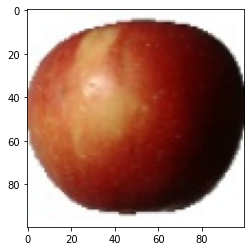

In [1]:
%%time

import imageio
im = imageio.imread( r"fruits-360\Training\Apple Braeburn\0_100.jpg" )

import numpy as np
im = np.array(im)

import matplotlib.pyplot as plt
plt.imshow(im)

Note that the image is indeed 100×100 pixels color, just as the readme promissed.

Note that I used `%%time`. Some notes on using 
[magics](https://nbviewer.jupyter.org/github/ipython/ipython/blob/1.x/examples/notebooks/Cell%20Magics.ipynb)

 - **Line magics**: these are commands prepended by one `%` character 
   and whose arguments only extend to the end of the current line.
 - **Cell magics**: these use two percent characters as a marker `%%`, 
   and they receive as argument the whole body of the cell. 
   
and on [timing](https://stackoverflow.com/questions/17579357/time-time-vs-timeit-timeit).

- `time` runs ones and measures elapsed time.
- `timeit` is more accurate: (1) it repeats the tests many times; (2) it disables the garbage collector; 
  and (3) it picks the most accurate timer for your OS.
  
 See also [readthedocs](https://ipython.readthedocs.io/en/stable/interactive/magics.html).

## Reading all data

The images are spread over 131 directories (one for each category), so in order to read all images, we use the os module to traverse all directories.

As a quick test, let's make a list of the first 15 categories.

In [2]:
import os
os.listdir("fruits-360\Training")[0:15]

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado']

Note that the `\` in the code is frowned upon, because it is Windows specific. The `path.join` abstracts that away.

In [3]:
training_path = os.path.join("fruits-360","Training")
categories = os.listdir(training_path)
print( f"'{training_path}' has '{categories[0]}', '{categories[1]}', '{categories[2]}', ..." )

'fruits-360\Training' has 'Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', ...


Let's check that the test directory has the same categories.

In [4]:
testing_path = os.path.join("fruits-360","Test")
print( categories == os.listdir(testing_path) )

True


Following the convention, variable `x` will contain the inputs (all training images), and `y` the outputs (the fruit category). But I will append a "version number", because subsequent steps with change the values, and in a notebook it is handy to be able to rerun previous (experimental) steps.

Note that the code below will read 470 MB of Training data. That might take some time (a minutes?).

In [5]:
%%time

x0 = []
y0 = []
for ix,category in enumerate(categories) :
    category_path = os.path.join(training_path,category)
    for file_name in os.listdir(category_path) :
        file_path = os.path.join(category_path,file_name)
        image = imageio.imread( file_path )
        x0.append(image)
        y0.append(ix)

Wall time: 22.8 s


Let's check the array shape. According to the documentation, we should have 67692 images, of 100 by 100 pixels, each 3 color channels (red, gree, blue).

In [6]:
x1 = np.array(x0)
x1.shape

(67692, 100, 100, 3)

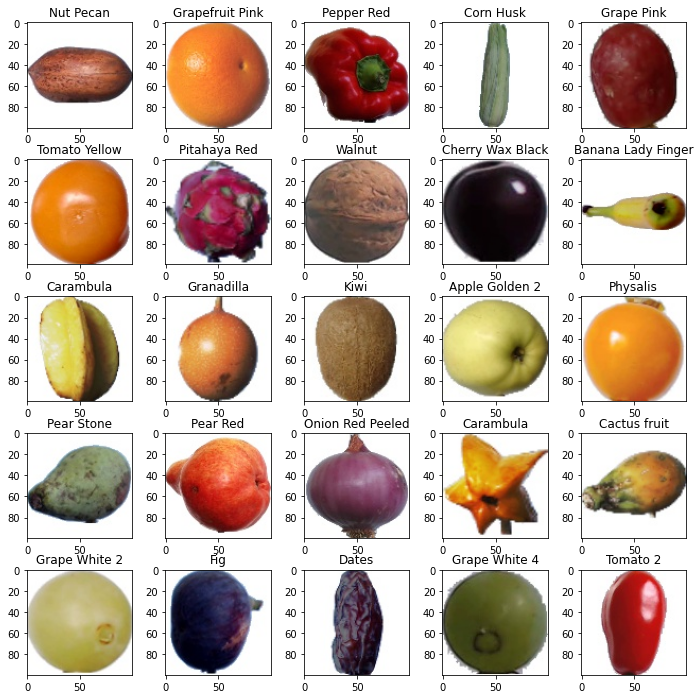

In [7]:
import random
n = 5
fig = plt.figure(n*n,figsize=(12,12))
fig.subplots_adjust(hspace=0.3)
for yy in range(n):
    for xx in range(n):
        ix = random.randrange(0, len(x0))
        ax = fig.add_subplot(n,n,yy*n+xx+1)
        ax.title.set_text(categories[y0[ix]])
        plt.imshow(x1[ix])

Recall that each pixel is stored as three values. Let us look at the upper left pixel `[0,0]` of image 0. We see that this is an array of three values, 254, 255, 255, so nearly white. And indeed the full range of a byte is used (0..255), but the mean is above 128, namely 150.

In [8]:
x1[0][0,0]

array([254, 255, 255], dtype=uint8)

In [9]:
x1.min(), x1.max()

(0, 255)

In [10]:
x1.mean()

150.1609877287321

The `max` above is over all color channels. I hoped that e.g. blue would not be so much present. I checked that with a histogram. I sliced over all images, and all coordinates, but only channel 2. This converts (67692,100,100,3) to (67692,100,100). Then I linearized that by passing -1 as new shape.

At first I was surprised there is so much blue. Then I realized that white also contains blue, and indeed there are over 100 million pixels with bue at 255.

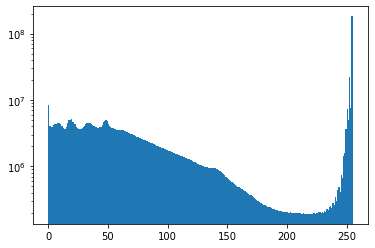

In [11]:
plt.hist(x1[:,:,:,2].reshape(-1),bins=256,log=True);

# Normalizing the data

Machine learning typically operates on floats in the range or around -1 to +1. So let's normalize our input pixel data.

In [12]:
x2 = x1.astype(np.float32)
x3 = x2 / 255.0 * 2.0
train_x = x3 - x3.mean()
train_x.shape, train_x.dtype

((67692, 100, 100, 3), dtype('float32'))

For the y values, we do a different sort of normalization. Recall that `y` is a list that records for each of the 67692 images to which of the 131 categories it belongs. For example, image 54321 has category 105 (Pomegranate).

In [13]:
len(y0), min(y0), max(y0), y0[54321], categories[y0[54321]]

(67692, 0, 130, 105, 'Pomegranate')

We now convert that list into a two-dimensional array of "checkmarks". After conversion, there will be 67692 rows (one for each fruit), and there will be 131 columns (one for each category). The cells are 0 (not checked, this fruit does not belong to this category) or 1 (checked, this fruit does belong to this category). Every row has exactly one times a 1.

I tried to illustrate the mapping from list to two-dimensional array in the picture below. Since we read the images per category, the 1's in the 2D array form a diagonal.

![map to categorical](to_categorical.png)

In [14]:
from tensorflow import keras
y1 = keras.utils.to_categorical(y0)

If we look at image 54321, we see the change from `y0` to `y1`: a single category (105) to an array of 130 checkmarks, with only slot 105 having a 1.

In [15]:
y0[54321]

105

In [16]:
y1[54321]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [17]:
y1[54321,105]

1.0

The total number of checkmarks equals the number of rows:

In [18]:
np.sum(y1)

67692.0

The reason for this format is how classification is usually approached in machine learning.

Each image now has a vector of 131 checkmarks. However, we should not regard the elements as checkmarks but as probabilities. For the training set, the vector is the ground truth. There is precisely one element at 1.0, e.g. "image 54321 has 100% probability to be a Pomegranate".

Later, when we use the CNN for classification the network might be presented an apple, and it might output the "apple column" to 85% and say the "pear column" to 15%. This means the CNN is pretty sure the object is an apple, but it does have some similarities with a pear.

The categorical data is what we will use for training.

In [19]:
train_y = y1

In [20]:
train_x.shape, train_y.shape

((67692, 100, 100, 3), (67692, 131))

# The network

As network we take a convolutional neural network or CNN.

## Convolution 

_Convolutional_ means we have a so-called _kernel_ that sweeps over an input matrix to produce and output matrix. A kernel is a matrix with _weights_. Typically, a the kernel is small, and width and height are odd numbers. Typically, the weights sum to 1. The image below shows a 3×3 kernel.

![convolution kernel.png](convolution-kernel.png)

This kernel sweeps over the input matrix. The diagram below shows the kernel on an arbitrary location ("x") of an input image. When the kernel is at location "x" it multiplies the 9 cells around (and including) "x" with the kernel weights, sums all 9 values, and this weighted average is output for that location "x". 

![convolution image.png](convolution-img.png)

During the convolution the kernel visits cell, each time computes the weighted average, outputs that, and thus forms a complete output matrix.

The diagram below shows an example with an input matrix of 5×4 where the 3×3 kernel from above is used to compute an output matrix. For example, (0.1×100 + 0.2×110 + 0×120) + (0.2×100 + 0.3×120 + 0.1×140) + (0×100 + 0.1×130 + 0×160) = 115. The behavior at the edges is special, easiest is to decrease the output size with the kernel size (minus 1).

![convolution numerical.png](convolution-num.png)



In [21]:
(0.1*100 + 0.2*110 + 0*120) + (0.2*100 + 0.3*120 + 0.1*140) + (0*100 + 0.1*130 + 0*160)

115.0

## Neurons

In a convolutional neural network (CNN), we have a kernel that sweeps over an "image" at layer _n_ to produce and "image" at layer _n+1_. The weights of the kernel are determined by learning. This means that the amount of weights is relatively small: we have to map a (large) input image to a (large) output image, but we only have to train the weights in a small kernel.

There is one complication, the "image" at each layer has multiple planes. This means that the kernel is not two-dimensional (2D) but a three-dimensional (3D) matrix. In the diagram below the input "image" has a width of 8, a height of 7 and a depth of 2 (light blue). This means that a 2D kernel of 3×3 is actually a 3D matrix of 3×3×2 (dark blue). The kernel, and hence the neuron (see the creditcard notebook for an introduction) has 18 weights, and on top of that one bias.

![Weights](weights.png)

With these 19 parameters, the dark green cell can be computed. By sweeping the kernel, one complete plane in the output "image" can be computed. If there are 4 output planes, as in the image above, we need 4 of those kernels, and thus 4×19 or 76 parameters need to be trained.

In the world of CNNs, the (oputput) planes are often refered to as _features_ and the neuron for that plane is trained to be activated (outputting 1) when that feature occurs.

## Funnel

CNN are well suited to do image classification. We are going to construct a 10 (11?) layer convolutional neural network. It has a typical funnel shape. We begin with the input layer, which has an input resolution of 100×100 and a depth of 3 planes (the three color channels: red, green and blue). When we go through the layers the resolution becomes smaller and smaller, but the number of planes ("features") increases. At the first step, we go from 100×100×3 to 98×98×16, the increase in depth is a choice from us, the decrease in resolution is the edge effect of convolution.

![CNN Funnel](funnel.png)

At the third step we not only double the number of planes (the depth) but we also make an explicit jump in resolution by clubbing 2×2 pixels. So we go from 96×96×16 to 47×47×32.

## The code

let us now setup the network with _keras_. We have a sequential network of convolution layers (`Conv2D`). For each layer we use a `(3,3)` kernel, and `'relu'` as activation function. The `padding='valid'` means that we chose to shrink the edge with the kernel size. We have the resolution step-down (`strides=(2,2)`) now and then. 

At the end of this halving/doubling porcess, we have a layer with a resolution of 7×7 and a feature depth of 128. We need 131 features (categories), so we append a `Conv2D(131,(1,1))`. Finally we average the 7×7 image to one pixel (`GlobalAveragePooling2D`) and activate it via softmax.

In [20]:
from tensorflow import keras
model = keras.models.Sequential()
# 100×100×3
model.add(keras.layers.Conv2D( 16,(3,3),padding='valid',activation='relu',input_shape=(100,100,3)))
# 98×98×16
model.add(keras.layers.Conv2D( 16,(3,3),padding='valid',activation='relu'))
# 96×96×16
model.add(keras.layers.Conv2D( 32,(3,3),padding='valid',activation='relu',strides=(2,2)))
# 47×47×32
model.add(keras.layers.Conv2D( 32,(3,3),padding='valid',activation='relu'))
# 45×45×32
model.add(keras.layers.Conv2D( 64,(3,3),padding='valid',activation='relu',strides=(2,2)))
# 22×22×64
model.add(keras.layers.Conv2D( 64,(3,3),padding='valid',activation='relu'))
# 20×20×64
model.add(keras.layers.Conv2D(128,(3,3),padding='valid',activation='relu',strides=(2,2)))
# 9×9×128
model.add(keras.layers.Conv2D(128,(3,3),padding='valid',activation='relu'))
# 7×7×128
model.add(keras.layers.Conv2D(131,(1,1)))
# 7×7×131
model.add(keras.layers.GlobalAveragePooling2D())
# 131
model.add(keras.layers.Activation('softmax'))
# 131

The "shape" comments in the above code fragment comes from the design picture, but we can also get that from the model:

In [19]:
for layer in model.layers:
    print( f"{layer.input_shape} -> {layer.output_shape}")

(None, 100, 100, 3) -> (None, 98, 98, 16)
(None, 98, 98, 16) -> (None, 96, 96, 16)
(None, 96, 96, 16) -> (None, 47, 47, 32)
(None, 47, 47, 32) -> (None, 45, 45, 32)
(None, 45, 45, 32) -> (None, 22, 22, 64)
(None, 22, 22, 64) -> (None, 20, 20, 64)
(None, 20, 20, 64) -> (None, 9, 9, 128)
(None, 9, 9, 128) -> (None, 7, 7, 128)
(None, 7, 7, 128) -> (None, 7, 7, 131)
(None, 7, 7, 131) -> (None, 131)
(None, 131) -> (None, 131)


Let us now compile the network and check the parameters.

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 128)         7

The first step brings us from 100×100×3 to 98×98×16 with a 3×3 kernel. Recall that the kernel has a depth of 3 and 1 bias, so we need 3×3×3+1 or 28 parameters per output plane. We designed 16 output planes, so in total we need 16×28 = 448 parameters. This matches the first row in the table above.

Let's do one more. Step 3 goes from 96×96×16 to 47×47×32, again with a 3×3 kernel. The kernel now has a depth of 16, so the we need 3×3×16+1 or 145 parameters per output pane. We have 32 output panes so 32×145 or 4640 parameters are needed for step 3. This matches the third row.

# Training

Training the network requires one line of code but a lot of time.
Note that we do not yet have _test_ data loaded, so we can not show the progress on validation.

```python
model.fit(train_x,train_y,epochs=10, batch_size=128, shuffle=True, validation_data=(test_x,test_y))
```

In [24]:
%%time
model.fit(train_x,train_y,epochs=10, batch_size=128, shuffle=True)

Epoch 1/10
529/529 [==============================] - 297s 560ms/step - loss: 1.6462 - accuracy: 0.5626
Epoch 2/10
529/529 [==============================] - 294s 556ms/step - loss: 0.2205 - accuracy: 0.9297
Epoch 3/10
529/529 [==============================] - 293s 553ms/step - loss: 0.0998 - accuracy: 0.9696
Epoch 4/10
529/529 [==============================] - 298s 563ms/step - loss: 0.0473 - accuracy: 0.9863
Epoch 5/10
529/529 [==============================] - 293s 554ms/step - loss: 0.0492 - accuracy: 0.9856
Epoch 6/10
529/529 [==============================] - 293s 553ms/step - loss: 0.0393 - accuracy: 0.9888
Epoch 7/10
529/529 [==============================] - 293s 553ms/step - loss: 0.0299 - accuracy: 0.9910
Epoch 8/10
529/529 [==============================] - 292s 552ms/step - loss: 0.0346 - accuracy: 0.9898
Epoch 9/10
529/529 [==============================] - 294s 555ms/step - loss: 0.0269 - accuracy: 0.9917
Epoch 10/10
529/529 [==============================] - 295s 557m

Each epoch takes a litte below 300s, so the total fit took 3000 seconds or 50 minutes.
Let's save, so that we don't have to retrain each time.

In [25]:
model.save('fruitfind.h5')

# Use the model

Let's see if the model can now predict the category of some fruit.

In case we did not rerun the trainig, we can load a previously saved model.

In [26]:
from tensorflow import keras
model2 = keras.models.load_model('fruitfind.h5')

## Pomgrenade

Let's start by classifying traing fruit item 54321, the pomgrenade.

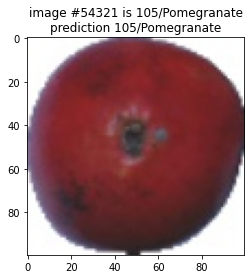

In [27]:
ix=54321
out=model2.predict(train_x[ix:ix+1]).reshape(-1)
cat=np.argmax(out)

fig = plt.figure()
ax = fig.add_subplot()
ax.title.set_text(f"image #{ix} is {y0[ix]}/{categories[y0[ix]]}\nprediction {cat}/{categories[cat]}")
plt.imshow(x1[ix]);

## Internet image

I downloaded an image of a raspberry. I did the scaling to 100×100 in an image tool. I also removed the background (i.e. made it white). Let's load and see it.

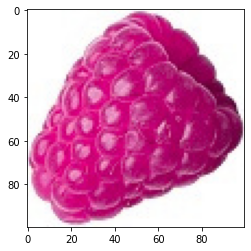

In [28]:
img = imageio.imread( r"raspberry.jpg" )
#from PIL import Image
#img = Image.fromarray(img).resize((100, 100))
img = np.array(img)
plt.imshow(img);

We must convert this to a singleton list or floats in the range -1..+1.

In [29]:
img = img.reshape((1,100,100,3))
img = img.astype(np.float32)
img = img / 255.0 * 2.0
img = img - img.mean()
img.shape

(1, 100, 100, 3)

Then we can try to classify it.

In [30]:
out=model2.predict(img).reshape(-1)
cat=np.argmax(out)

print( f"prediction {cat}/{categories[cat]}" )

prediction 113/Raspberry


# Validate the model

To validate the model, we must load and normalize the test data. We take the same steps as for traing, but now start with the `testing_path`.

In [31]:
# Empty arrays for test input and output
xx0 = []
yy0 = []

# Read test data from filesystem (directory `testing_path`)
for ix,category in enumerate(categories) :
    category_path = os.path.join(testing_path,category)
    for file_name in os.listdir(category_path) :
        file_path = os.path.join(category_path,file_name)
        image = imageio.imread( file_path )
        xx0.append(image)
        yy0.append(ix)

# Convert images to numpy array        
xx1 = np.array(xx0)

# Convert pixels from byte to float
xx2 = xx1.astype(np.float32)

# Normalize to (roughly) -1..+1
xx3 = xx2 / 255.0 * 2.0
test_x = xx3 - xx3.mean()

# Print key metrics for input
print(test_x.shape)
print(test_x.dtype)

# Convert output scalars to output arrays
test_y = keras.utils.to_categorical(yy0)

# Print key metrics for output
print(test_y.shape)
print(test_y.dtype)

(22688, 100, 100, 3)
float32
(22688, 131)
float32


We can now validate by evaluating the test set.

In [32]:
model2.evaluate(test_x, test_y)

709/709 [==============================] - 22s 31ms/step - loss: 0.2483 - accuracy: 0.9587


[0.24825699627399445, 0.9587006568908691]

This returns the computed loss and accuracy of the test set.

(end)